<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Chapter 5

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import dc_stat_think as dcst

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
# data prep
from urllib.request import urlretrieve

url = 'https://assets.datacamp.com/production/repositories/1067/datasets/c12865c9df2b6e63a40a53eaeee7caffb6cf87ac/'
file = 'oklahoma_earthquakes_1950-2017.csv'
urlretrieve(url+file, file)
df = pd.read_csv(file, skiprows=2, parse_dates=['time'])
df.info()

from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

mags = df['mag'].values
time_gap = df['gap'].values
time = df['time'].apply(toYearFraction)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978 entries, 0 to 8977
Data columns (total 26 columns):
time               8978 non-null datetime64[ns]
latitude           8978 non-null float64
longitude          8978 non-null float64
depth              8978 non-null float64
mag                8978 non-null float64
magType            8970 non-null object
nst                722 non-null float64
gap                8128 non-null float64
dmin               916 non-null float64
rms                8318 non-null float64
net                8978 non-null object
id                 8978 non-null object
updated            8978 non-null object
place              8978 non-null object
type               8978 non-null object
horizontalError    6968 non-null float64
depthError         8190 non-null float64
magError           1206 non-null float64
magNst             1344 non-null float64
status             8978 non-null object
locationSource     8978 non-null object
magSource          8978 non-null ob

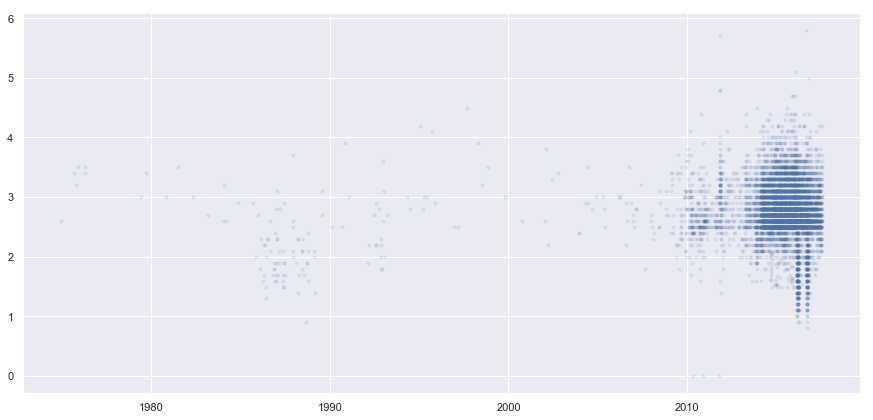

In [3]:
plt.figure(figsize=(15,7))

# Plot time vs. magnitude
_ = plt.plot(time, mags, marker='.', linestyle='none', alpha=0.1)

# Label axes and show the plot
#_ = plt.xlabel('time (year)')
#_ = plt.ylabel('magnitude')
plt.show()


In [4]:
# create a data frame with just 3.0 and above events
# shift the time
# then measure the days between these events - that's why my figures are wrong

df_3_mag = df[df['mag']>=3]
df_3_mag['shift_time'] = df_3_mag['time'].shift()
df_3_mag['dt_gap'] = df_3_mag['time'] - df_3_mag['shift_time']
df_3_mag = df_3_mag[~df_3_mag['dt_gap'].isna()]
df_3_mag['gap'] = df_3_mag['dt_gap'] / pd.Timedelta(days=1)

df_3_mag.set_index('time', inplace=True)
dt_pre = df_3_mag.loc[:'2009', 'gap']
dt_post = df_3_mag.loc['2010':, 'gap']

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [5]:
# Compute mean interearthquake time
mean_dt_pre = np.mean(dt_pre)
mean_dt_post = np.mean(dt_post)

# Draw 10,000 bootstrap replicates of the mean
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post, np.mean, size=10000)

# Compute the confidence interval
conf_int_pre = np.percentile(bs_reps_pre, [2.5, 97.5])
conf_int_post = np.percentile(bs_reps_post, [2.5, 97.5])

# Print the results
print("""1980 through 2009
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_pre, *conf_int_pre))

print("""
2010 through mid-2017
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_post, *conf_int_post))


1980 through 2009
mean time gap: 212.16 days
95% conf int: [145.97, 284.82] days

2010 through mid-2017
mean time gap: 1.13 days
95% conf int: [0.98, 1.31] days


In [6]:
# Compute the observed test statistic
mean_dt_diff = mean_dt_pre - mean_dt_post

# Shift the post-2010 data to have the same mean as the pre-2010 data
dt_post_shift = dt_post - mean_dt_post + mean_dt_pre

# Compute 10,000 bootstrap replicates from arrays
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post_shift, np.mean, size=10000)

# Get replicates of difference of means
bs_reps = bs_reps_pre - bs_reps_post

# Compute and print the p-value
p_val = np.sum(bs_reps >= mean_dt_diff) / 10000
print('p =', p_val)

p = 0.0


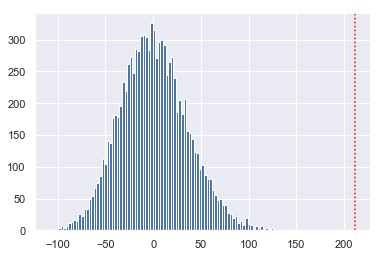

In [7]:
# extra visualisation
plt.hist(bs_reps, bins=100)
plt.axvline(mean_dt_diff, color='red', linestyle=':')
plt.show()

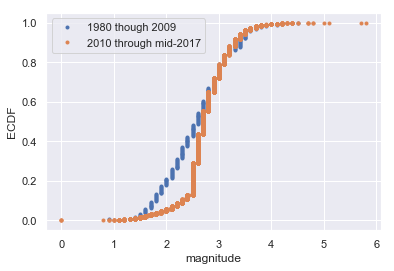

In [8]:
# Get magnitudes before and after 2010
mags_pre = mags[time < 2010]
mags_post = mags[time >= 2010]

# Generate ECDFs
_ = plt.plot(*dcst.ecdf(mags_pre), marker='.', linestyle='none')
_ = plt.plot(*dcst.ecdf(mags_post), marker='.', linestyle='none')

# Label axes and show plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
plt.legend(('1980 though 2009', '2010 through mid-2017'), loc='upper left')
plt.show()


In [9]:
# data prep
mt = 3

In [10]:
# Compute b-value and confidence interval for pre-2010
b_pre, conf_int_pre = dcst.b_value(mags_pre, mt, perc=[2.5, 97.5], n_reps=10000)

# Compute b-value and confidence interval for post-2010
b_post, conf_int_post = dcst.b_value(mags_post, mt, perc=[2.5, 97.5], n_reps=10000)

# Report the results
print("""
1980 through 2009
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]

2010 through mid-2017
b-value: {3:.2f}
95% conf int: [{4:.2f}, {5:.2f}]
""".format(b_pre, *conf_int_pre, b_post, *conf_int_post))



1980 through 2009
b-value: 0.75
95% conf int: [0.56, 0.95]

2010 through mid-2017
b-value: 0.62
95% conf int: [0.60, 0.65]



Correct! For instructional purposes, here are reasons why each is true:
- Option 1 is true because below the completeness threshold, we are not comparing earthquakes before and after 2010, but observed earthquakes before and after 2010. We do not have a complete data set below the completeness threshold.
- Option 2 is true because we really are assuming the Gutenberg-Richter law holds, in part because we are only considering earthquakes above the completeness threshold. We are using a model (the G-R law) to deal with missing data. So, since both sets of quakes follow the same statistical model, and that model has a single parameter, a permutation test is appropriate.
- Option 3 is true, even though you may be thinking that the mean values are not the b-values, and that you should be using the difference in b-value as your test statistic. However, the difference in mean magnitude is directly proportional to the difference in b-value, so the result of the hypothesis test will be identical if we use b-values of mean magnitudes.
- Option 4 is true because even though they have different numbers of earthquakes, you are only interested in summary statistics about their magnitude. There were 53 earthquakes between 1980 and 2009 with magnitude 3 or greater, so we have enough to compute a reliable mean.
- Option 5 is true because, provided the time interval is long enough, the b-value is independent of the time interval, just like the mean of Exponentially distributed values is independent of how many there are, provided there are not too few.

In [11]:
# Only magnitudes above completeness threshold
mags_pre = mags_pre[mags_pre >= 3]
mags_post = mags_post[mags_post >= 3]

# Observed difference in mean magnitudes: diff_obs
diff_obs = np.mean(mags_post) - np.mean(mags_pre)

# Generate permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(mags_post, mags_pre, dcst.diff_of_means, size=10000)

# Compute and print p-value
p_val = np.sum(perm_reps < diff_obs) / 10000
print('p =', p_val)

p = 0.0784


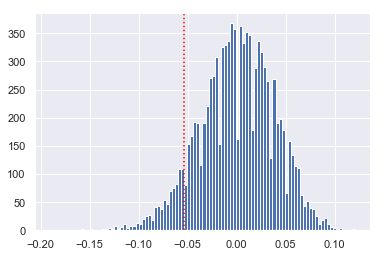

In [12]:
# extra visualisation
plt.hist(perm_reps, bins=100)
plt.axvline(diff_obs, color='red', linestyle=':')
plt.show()